### Function structure ###

*Functions for validation*
* trial_llh_simple
* trial_llh_set_simple
* trial_nonorm_posterior_simple
* trial_nonorm_posterior_set_simple
* trial_nonorm_posterior_transformed (key function, validated through the other functions in this section)
* trial_nonorm_posterior_set_valid
* trial_nonorm_posterior_set_breakdown

*Functions that can be integrated with a general library*
* gamma_posterior (implicitly validated)
* model_marginal_llh (kan be validated through sampling)

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from numpy.linalg import inv
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math

In [2]:
gamma = np.array([1,1]) * 1/np.sqrt(2)
sigma_r = 0.4
Sigma_r = np.array([[1,0],[0,1]]) * 1.1
Sigma_0 = np.array([[1,0],[0,1]])
z = np.array([-0.4,2.5])
r = 2.3
z2 = np.array([[-0.4,2.5],[0.8, -0.5]])
r2 = [2.3, -1.2]
zT = np.array([[-0.4,2.5],[0.8, -0.5], [2, 0.4]])
rT = [2.3, -1.2, 0.4]
zT = np.random.normal(0, 1, (6, 2))
rT = np.random.normal(0, 1, 6)

In [3]:
def trial_llh_simple(z, r, gamma, sigma_r):
    # likelihood for a single data point
    y = multivariate_normal.pdf(r, mean = np.dot(gamma,z), cov = sigma_r**2)
    return y

In [4]:
def trial_llh_set_simple(zs, rs, gamma, sigma_r):
    # likelihood for a data set
    T = np.size(zs,0)
    y = 1
    for t in range(T):
        z = zs[t]
        r = rs[t]
        y = y * trial_llh_simple(z, r, gamma, sigma_r)
    return y

In [5]:
def trial_nonorm_posterior_simple(z, r, gamma, sigma_r, Sigma_0):
    # gamma posterior for a single data point -- in fact this is the non-normalized normal distribution that comes from the combination of the llh with the prior
    # this is the most straighforward way to calculate it, without any clear math
    y = trial_llh_simple(z, r, gamma, sigma_r) * multivariate_normal.pdf(gamma, mean = np.array([0,0]), cov = Sigma_0)
    return y

In [6]:
def trial_nonorm_posterior_set_simple(zs, rs, gamma, sigma_r, Sigma_0):
    # gamma posterior for a data set -- in fact this is the non-normalized normal distribution that comes from the combination of the llh with the prior
    # this is the most straighforward way to calculate it, without any clear math
    y = trial_llh_set_simple(zs, rs, gamma, sigma_r) * multivariate_normal.pdf(gamma, mean = np.array([0,0]), cov = Sigma_0)
    return y

In [7]:
def trial_nonorm_posterior_transformed(z, r, gamma, sigma_r, Sigma_0):
    # the non-normalized posterior for a single data point
    # this implementation is based on the math shwon in the onenote derivation
    zeta = 1/math.sqrt(2*math.pi)
    detSigma_0 = np.linalg.det(Sigma_0)
    Sigma_1_star_inv = np.array([[z[0]**2/sigma_r**2, z[0]*z[1]/sigma_r**2],[z[0]*z[1]/sigma_r**2, z[1]**2/sigma_r**2]])
    Sigma_1_inv = Sigma_1_star_inv + np.linalg.inv(Sigma_0)
    Sigma_1 = np.linalg.inv(Sigma_1_inv)
    mu_1 = Sigma_1.dot(z) *r/sigma_r**2
    
    #interim calculation of a core element of the posterior: here I check if the algebra was correct
    # all of the lines below should give the same results
    
    #interim = np.exp(-0.5 * (gamma.dot(Sigma_1_star_inv.dot(gamma)) - 2*r/sigma_r**2 * z.dot(gamma) + r**2/sigma_r**2) - 0.5* gamma.dot(np.linalg.inv(Sigma_0).dot(gamma)))
    #print(interim)
    #interim = np.exp(-0.5 * (gamma.dot(Sigma_1_inv.dot(gamma)) - 2*mu_1.dot(Sigma_1_inv).dot(gamma)) )  * np.exp(-0.5*r**2/sigma_r**2)
    #print(interim)
    #gm = gamma - mu_1
    #interim = np.exp(-0.5 * (gm.dot(Sigma_1_inv.dot(gm)) - mu_1.dot(Sigma_1_inv).dot(mu_1)) ) * np.exp(-0.5*r**2/sigma_r**2)
    #print(interim)
    #interim = np.exp(-0.5 * (gm.dot(Sigma_1_inv.dot(gm)))) /  multivariate_normal.pdf(mu_1, mean = np.array([0,0]), cov = Sigma_1) / (2* math.pi / np.sqrt(np.linalg.det(Sigma_1_inv)))
    #print(interim)
    #interim = multivariate_normal.pdf(gamma, mean = mu_1, cov =  Sigma_1) /  multivariate_normal.pdf(mu_1, mean = np.array([0,0]), cov = Sigma_1) * np.exp(-0.5*r**2/sigma_r**2)
    #print(interim)
    #interim = multivariate_normal.pdf(gamma, mean = mu_1, cov =  Sigma_1) /  multivariate_normal.pdf(mu_1, mean = np.array([0,0]), cov = Sigma_1) * multivariate_normal.pdf(r, mean = 0, cov = sigma_r**2) *np.sqrt(2*math.pi)*sigma_r
    #print(interim)
    y = 1/(2*math.pi)/np.sqrt(np.linalg.det(Sigma_0)) * multivariate_normal.pdf(gamma, mean = mu_1, cov =  Sigma_1) /  multivariate_normal.pdf(mu_1, mean = np.array([0,0]), cov = Sigma_1) * multivariate_normal.pdf(r, mean = 0, cov = sigma_r**2)
    return y


In [8]:
def trial_nonorm_posterior_set_transformed(zs, rs, gamma, sigma_r, Sigma_0):
    # this is the non-normalized posterior that is the argument of the integral of the mmLLH
    # it is a transformation of \prod_i p(z_i, r_i | c, gamma) * p(\gamma | c) -- notation as in the 'CL marginal likelihood 2' calculation in onenote
    # the end result looks like this
    # 1/2/\pi * det(\Sigma_0)^{-1/2} \prod_i N(r_i; 0, \sigma_r^2) / N(\mu_T; 0, \Sigma_T) * N(\gamma; \mu_T, \Sigma_T)
    # THIS IS THE CORE FUNCTION OF THE VALIDATION, ALL THE MATH BOILS DOWN HERE
    T = np.size(zs,0)
    detSigma_0 = np.linalg.det(Sigma_0)
    Sigma_i_star_invs = []
    Sigma_i_invs = []
    mu_is = []
    y = 1/(2*math.pi)/np.sqrt(np.linalg.det(Sigma_0))
    for t in range(T):
        z = zs[t]
        r = rs[t]
        Sigma_i_star_inv = np.array([[z[0]**2/sigma_r**2, z[0]*z[1]/sigma_r**2],[z[0]*z[1]/sigma_r**2, z[1]**2/sigma_r**2]])
        Sigma_i_star_invs.append(Sigma_i_star_inv)
        if t==0:
            Sigma_i_inv = Sigma_i_star_inv + np.linalg.inv(Sigma_0)
        else:
            Sigma_i_inv = Sigma_i_star_inv + Sigma_i_invs[t-1]
        Sigma_i_invs.append(Sigma_i_inv)
        Sigma_i = np.linalg.inv(Sigma_i_inv)
        if t==0:
            mu_i = Sigma_i.dot(z*r/sigma_r**2)
        else:
            mu_i = Sigma_i.dot(z*r/sigma_r**2 + Sigma_i_invs[t-1].dot(mu_is[t-1]) )
        mu_is.append(mu_i)
        y = y * multivariate_normal.pdf(r, mean = 0, cov = sigma_r**2)
    y = y / multivariate_normal.pdf(mu_i, mean = np.array([0,0]), cov = Sigma_i) * multivariate_normal.pdf(gamma, mean = mu_i, cov =  Sigma_i)
    return y

In [9]:
def trial_nonorm_posterior_set_valid(zs, rs, gamma, sigma_r, Sigma_0):
    #non-normalized gamma posterior for two data points, for validation purposes
    T = np.size(zs,0)
    t = 0
    z = zs[t]
    r = rs[t]
    y = trial_nonorm_posterior_transformed(z, r, gamma, sigma_r, Sigma_0)
    t = 1
    z = zs[t]
    r = rs[t]
    y = y * trial_llh_simple(z, r, gamma, sigma_r)
    return y


In [10]:
def trial_nonorm_posterior_set_breakdown(zs, rs, gamma, sigma_r, Sigma_0):
    #non-normalized gamma posterior for two data points, for validation purposes
    T = np.size(zs,0)
    t = 0
    z = zs[t]
    r = rs[t]
    detSigma_0 = np.linalg.det(Sigma_0)
    Sigma_1_star_inv = np.array([[z[0]**2/sigma_r**2, z[0]*z[1]/sigma_r**2],[z[0]*z[1]/sigma_r**2, z[1]**2/sigma_r**2]])
    Sigma_1_inv = Sigma_1_star_inv + np.linalg.inv(Sigma_0)
    Sigma_1 = np.linalg.inv(Sigma_1_inv)
    mu_1 = Sigma_1.dot(z) *r/sigma_r**2
    y = 1/(2*math.pi)/np.sqrt(np.linalg.det(Sigma_0)) * multivariate_normal.pdf(r, mean = 0, cov = sigma_r**2)
    t = 1
    z = zs[t]
    r = rs[t]
    Sigma_2_star_inv = np.array([[z[0]**2/sigma_r**2, z[0]*z[1]/sigma_r**2],[z[0]*z[1]/sigma_r**2, z[1]**2/sigma_r**2]])
    Sigma_2_inv = Sigma_2_star_inv + Sigma_1_inv
    Sigma_2 = np.linalg.inv(Sigma_2_inv)
    mu_2 = Sigma_2.dot(z*r/sigma_r**2 + Sigma_1_inv.dot(mu_1))
    y = y *  multivariate_normal.pdf(r, mean = 0, cov = sigma_r**2) / multivariate_normal.pdf(mu_2, mean = np.array([0,0]), cov = Sigma_2) * multivariate_normal.pdf(gamma, mean = mu_2, cov =  Sigma_2)
    return y



In [11]:
def gamma_posterior(zs, rs, gamma, sigma_r, Sigma_0):
    # this is the calculation of the posterior parameters, mu_T and Sigma_T of the posterior p(\gamma | D) = N(\gamma; mu_T, Sigma_T)
    # notation as in the 'CL marginal likelihood 2' calculation in onenote
    # the core derivation comes from the function 'trial_nonorm_posterior_set_transformed'
    T = np.size(zs,0)
    detSigma_0 = np.linalg.det(Sigma_0)
    Sigma_i_star_invs = []
    Sigma_i_invs = []
    mu_is = []
    for t in range(T):
        z = zs[t]
        r = rs[t]
        Sigma_i_star_inv = np.array([[z[0]**2/sigma_r**2, z[0]*z[1]/sigma_r**2],[z[0]*z[1]/sigma_r**2, z[1]**2/sigma_r**2]])
        Sigma_i_star_invs.append(Sigma_i_star_inv)
        if t==0:
            Sigma_i_inv = Sigma_i_star_inv + np.linalg.inv(Sigma_0)
        else:
            Sigma_i_inv = Sigma_i_star_inv + Sigma_i_invs[t-1]
        Sigma_i_invs.append(Sigma_i_inv)
        Sigma_i = np.linalg.inv(Sigma_i_inv)
        if t==0:
            mu_i = Sigma_i.dot(z*r/sigma_r**2)
        else:
            mu_i = Sigma_i.dot(z*r/sigma_r**2 + Sigma_i_invs[t-1].dot(mu_is[t-1]) )
        mu_is.append(mu_i)
    mu_T = mu_i
    Sigma_T = Sigma_i
    return mu_T, Sigma_T

In [12]:
def model_marginal_llh(zs, rs, gamma, sigma_r, Sigma_0):
    # this is the model marginal likelihood function
    # it is validated through 'trial_nonorm_posterior_set_transformed'
    # from that function the only step fowrad is to leave the normal in gamma (the gamma posterior) since gamma is marginalized out
    T = np.size(zs,0)
    detSigma_0 = np.linalg.det(Sigma_0)
    Sigma_i_star_invs = []
    Sigma_i_invs = []
    mu_is = []
    y = 1/(2*math.pi)/np.sqrt(np.linalg.det(Sigma_0))
    for t in range(T):
        z = zs[t]
        r = rs[t]
        Sigma_i_star_inv = np.array([[z[0]**2/sigma_r**2, z[0]*z[1]/sigma_r**2],[z[0]*z[1]/sigma_r**2, z[1]**2/sigma_r**2]])
        Sigma_i_star_invs.append(Sigma_i_star_inv)
        if t==0:
            Sigma_i_inv = Sigma_i_star_inv + np.linalg.inv(Sigma_0)
        else:
            Sigma_i_inv = Sigma_i_star_inv + Sigma_i_invs[t-1]
        Sigma_i_invs.append(Sigma_i_inv)
        Sigma_i = np.linalg.inv(Sigma_i_inv)
        if t==0:
            mu_i = Sigma_i.dot(z*r/sigma_r**2)
        else:
            mu_i = Sigma_i.dot(z*r/sigma_r**2 + Sigma_i_invs[t-1].dot(mu_is[t-1]) )
        mu_is.append(mu_i)
        y = y * multivariate_normal.pdf(r, mean = 0, cov = sigma_r**2)
    y = y / multivariate_normal.pdf(mu_i, mean = np.array([0,0]), cov = Sigma_i)
    return y

In [13]:
# one datapoint validation of gamma posterior
print(trial_nonorm_posterior_simple(z, r, gamma, sigma_r, Sigma_0))
print(trial_nonorm_posterior_transformed(z, r, gamma, sigma_r, Sigma_0))
print(trial_nonorm_posterior_transformed(z, r, gamma, sigma_r, Sigma_0)/trial_nonorm_posterior_simple(z, r, gamma, sigma_r, Sigma_0))

0.012075050338033355
0.012075050338033301
0.9999999999999956


In [14]:
# two-datapoints validation of gamma posterior
print(trial_nonorm_posterior_set_simple(z2, r2, gamma, sigma_r, Sigma_0))
print(trial_nonorm_posterior_set_valid(z2, r2, gamma, sigma_r, Sigma_0))
print(trial_nonorm_posterior_set_breakdown(z2, r2, gamma, sigma_r, Sigma_0))
print(trial_nonorm_posterior_set_transformed(z2, r2, gamma, sigma_r, Sigma_0))

2.368006578969691e-05
2.3680065789696804e-05
2.3680065789696865e-05
2.368006578969665e-05


In [15]:
# N-datapoints validation of gamma posterior
zs = zT
rs = rT
print(trial_nonorm_posterior_set_simple(zs, rs, gamma, sigma_r, Sigma_0))
print(trial_nonorm_posterior_set_transformed(zs, rs, gamma, sigma_r, Sigma_0))
print(trial_nonorm_posterior_set_simple(zs, rs, gamma, sigma_r, Sigma_0)/trial_nonorm_posterior_set_transformed(zs, rs, gamma, sigma_r, Sigma_0))

5.642180008760846e-23
5.642180008760841e-23
1.0000000000000009


In [16]:
zs = zT
rs = rT
mu_T, Sigma_T = gamma_posterior(zs, rs, gamma, sigma_r, Sigma_0)
print(mu_T)
print(Sigma_T)

[0.262081   0.02383172]
[[ 0.14432371 -0.04430244]
 [-0.04430244  0.03493169]]


In [18]:
N = 30
gammas = np.linspace(-4,4,N)

gamma_post_T1 = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        gamma_post_T1[i][j]= trial_nonorm_posterior_transformed(z, r, np.array([gammas[i],gammas[j]]), sigma_r, Sigma_0)

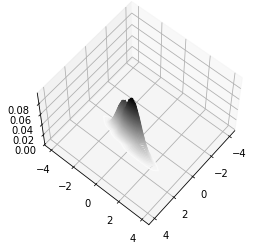

In [19]:
X, Y = np.meshgrid(gammas, gammas)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, gamma_post_T1, 50, cmap='binary')
ax.view_init(elev=60, azim=40)